# Code Similarity: A Machine Learning Project

## Project Inicialization

In [4]:
import json, time, os
from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)
pd.set_option('display.max_columns', None)


## Extrayendo Los AST

In [5]:

# PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

# DATA_FOLDER = f'{os.getcwd()}/data/'

# os.makedirs(DATA_FOLDER, exist_ok=True)

# project_features = []

# for f in os.scandir(PROJECTS_FOLDER):
#     if f.is_dir():
#         print(PROJECTS_FOLDER + f.name)
        
#         features = process_project(PROJECTS_FOLDER + f.name)
#         features['project_name'] = f.name
#         project_features.append(features)

# # Generar un nombre de archivo JSON único usando la marca de tiempo
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# # Guardar los features en un archivo JSON
# with open(output_json_path, 'w', encoding='utf-8') as json_file:
#     json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

## MOSS Baseline

## Data Loading

In [6]:
raw_data = pd.read_json('data/merged_features.json')
raw_data


,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,number_of_sealed_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,control_structures_dowhile,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,access_modifiers_protected_internal,access_modifiers_private_protected,modifier_readonly,modifier_volatile,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_unsafe,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_groupBy,linq_queries_join,linq_queries_sum,linq_queries_count,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,node_count,project_name,label,project_type,variable_names_vector,delegate_names_vector,method_return_types_vector,method_names_vector,class_names_vector,interface_names_vector,enums_names_vector,method_parameters_vector
0,134895,3130,154,0,0,0,152,33,33,0,0,31,13,9,5,0,0,413,234,3,22,3,0,285,46,20,0,54,0,0,0,0,18,11,45,2,0,0,0,10,0,0,0,0,28,0,0,1,3,126,74,0,50,"{'Compilation_unitContext': 56, 'Namespace_mem...",JoseMiguel01012570345_Domino,original,domino,"[-0.012726657092571002, 0.015388422645628001, ...",[],"[-0.020707672461867003, 0.026297831907868004, ...","[-0.010017288848757001, 0.013559108600020001, ...","[-0.002490584738552, 0.005718902219086001, 0.0...","[-0.0034030620008700004, 0.0055966735817490005...",[],"[-0.010241279378533, 0.013796883635222001, 0.0..."
1,50908,929,99,0,0,0,62,35,0,0,0,13,9,7,1,0,0,79,136,12,17,1,0,123,28,3,0,8,0,0,0,0,0,28,29,0,0,0,0,0,0,0,0,0,3,0,2,6,6,14,11,0,9,"{'Compilation_unitContext': 17, 'Using_directi...",Ramonconda_HulkProjec,original,hulk,"[0.002499217400327, 0.0018413322977720002, 0.0...",[],"[0.0013908025575800002, 0.0027287723496550002,...","[0.0006110234535290001, 0.0012744109844780001,...","[0.000853140198159, 0.00027786512509900003, 5....",[],[],"[-0.002294766483828, 0.005734340287744001, 0.0..."
2,21992,830,26,5,0,0,33,12,0,0,0,11,4,0,0,0,0,26,25,0,5,0,0,60,54,4,7,19,0,0,25,0,0,11,22,0,0,0,0,4,4,0,0,0,13,0,1,9,17,7,4,0,12,"{'Compilation_unitContext': 15, 'Using_directi...",0mar-rivero_moogle-2021,original,moogle,"[-0.004004274494946, 0.0037407751660790004, 0....",[],"[0.000608267495408, 0.0025440196041010004, -0....","[-0.0012229366693640002, -0.000522482441738, 0...","[-0.0017937920056280002, 0.0030078215058890003...",[],[],"[-0.00045094915549200005, -0.00010345679766, 0..."
3,38989,549,106,0,0,0,36,7,0,0,0,6,1,2,4,1,0,105,85,5,2,13,0,51,11,0,0,2,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,30,0,5,6,0,6,3,0,7,"{'Compilation_unitContext': 7, 'Using_directiv...",kmy-cyber_INTERPRETE-C--to-HULK,original,hulk,"[0.000262182526057, 0.0011837051715700001, -0....",[],"[-0.0010048762196670001, 0.003144263057038, -0...","[0.001262618694454, 0.001120802015066, -0.0018...","[-0.000535695871803, 0.001842815778218, 0.0024...",[],"[-0.00034204794792400004, 0.00410747108981, 0....","[3.640579598140903e-05, 0.002426245948299, -0...."
4,33426,859,109,0,0,0,28,9,0,0,0,1,0,3,1,0,0,44,69,0,41,0,0,73,1,0,0,54,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,2,0,0,6,0,32,31,1,9,"{'Compilation_unitContext': 10, 'Using_directi...",RodryJR_moogle,original,moogle,"[-0.0015021869912740001, 0.0031298745889210004...",[],"[-0.0014544894220300001, 0.002984559163451, 0....","[0.0006193788140080001, -0.0003405834140720000...","[0.001954318024218, 0.000805227609816, 0.00319...",[],[],"[0.0007984451949590001, -0.0003205263928970000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [7]:
# Step 1: Identify columns with list values dynamically
list_columns = [col for col in raw_data.columns if isinstance(raw_data[col].iloc[0], list)]

# Step 2-4: Expand and concatenate for each list column
for list_column in list_columns:
    # Expand the lists into multiple columns
    expanded_cols = pd.DataFrame(raw_data[list_column].tolist(), index=raw_data.index)
    
    # Rename the expanded columns to match desired output
    expanded_cols.columns = [f'{list_column}-{i+1}' for i in range(expanded_cols.shape[1])]
    
    # Drop the original list column and concatenate the expanded columns
    raw_data = raw_data.drop(columns=[list_column]).join(expanded_cols)

# Replace NaN with appropriate values if needed (e.g., 0 or '')
raw_data = raw_data.fillna(np.nan)  # Or any other value like 0 or ''

# raw_data[['interface_names_vector-1', 'project_name', 'label']]

raw_data = raw_data.drop(columns = ['label', 'delegate_names_vector-1', 'delegate_names_vector-2', 'node_count', 'project_name', 'modifier_volatile', 'access_modifiers_private_protected', 'access_modifiers_protected_internal', 'control_structures_dowhile', 'number_of_sealed_classes', 'modifier_volatile', 'modifier_unsafe', 'linq_queries_groupBy', 'linq_queries_count'])
raw_data = raw_data.fillna(0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 944 entries, total_nodes to method_parameters_vector-200
dtypes: float64(898), int64(45), object(1)
memory usage: 730.3+ KB


## Difference Data

In [8]:
import itertools
# from listener import 

numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])
component_wise_differences = []
# TODO: Get project name from original data
for (index1, row1), (index2, row2) in itertools.combinations(numeric_data.iterrows(), 2):
    difference = row1.values - row2.values
    component_wise_differences.append([index1, index2] + list(difference))
columns = ['Index1', 'Index2'] + list(numeric_data.columns)
component_wise_df = pd.DataFrame(component_wise_differences, columns=columns)
component_wise_df

component_wise_df.head()

,Index1,Index2,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,modifier_readonly,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_join,linq_queries_sum,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,variable_names_vector-1,variable_names_vector-2,variable_names_vector-3,variable_names_vector-4,variable_names_vector-5,variable_names_vector-6,variable_names_vector-7,variable_names_vector-8,variable_names_vector-9,variable_names_vector-10,variable_names_vector-11,variable_names_vector-12,variable_names_vector-13,variable_names_vector-14,variable_names_vector-15,variable_names_vector-16,variable_names_vector-17,variable_names_vector-18,variable_names_vector-19,variable_names_vector-20,variable_names_vector-21,variable_names_vector-22,variable_names_vector-23,variable_names_vector-24,variable_names_vector-25,variable_names_vector-26,variable_names_vector-27,variable_names_vector-28,variable_names_vector-29,variable_names_vector-30,variable_names_vector-31,variable_names_vector-32,variable_names_vector-33,variable_names_vector-34,variable_names_vector-35,variable_names_vector-36,variable_names_vector-37,variable_names_vector-38,variable_names_vector-39,variable_names_vector-40,variable_names_vector-41,variable_names_vector-42,variable_names_vector-43,variable_names_vector-44,variable_names_vector-45,variable_names_vector-46,variable_names_vector-47,variable_names_vector-48,variable_names_vector-49,variable_names_vector-50,variable_names_vector-51,variable_names_vector-52,variable_names_vector-53,variable_names_vector-54,variable_names_vector-55,variable_names_vector-56,variable_names_vector-57,variable_names_vector-58,variable_names_vector-59,variable_names_vector-60,variable_names_vector-61,variable_names_vector-62,variable_names_vector-63,variable_names_vector-64,variable_names_vector-65,variable_names_vector-66,variable_names_vector-67,variable_names_vector-68,variable_names_vector-69,variable_names_vector-70,variable_names_vector-71,variable_names_vector-72,variable_names_vector-73,variable_names_vector-74,variable_names_vector-75,variable_names_vector-76,variable_names_vector-77,variable_names_vector-78,variable_names_vector-79,variable_names_vector-80,variable_names_vector-81,variable_names_vector-82,variable_names_vector-83,variable_names_vector-84,variable_names_vector-85,variable_names_vector-86,variable_names_vector-87,variable_names_vector-88,variable_names_vector-89,variable_names_vector-90,variable_names_vector-91,variable_names_vector-92,variable_names_vector-93,variable_names_vector-94,variable_names_vector-95,variable_names_vector-96,variable_names_vector-97,variable_names_vector-98,variable_names_vector-99,variable_names_vector-100,delegate_names_vector-3,delegate_names_vector-4,delegate_names_vector-5,delegate_names_vector-6,delegate_names_vector-7,delegate_names_vector-8,delegate_names_vector-9,delegate_names_vector-10,delegate_names_vector-11,delegate_names_vector-12,delegate_names_vector-13,delegate_names_vector-14,delegate_names_vector-15,delegate_names_vector-16,delegate_names_vector-17,delegate_names_vector-18,delegate_names_vector-19,delegate_names_vector-20,delegate_names_vector-21,delegate_names_vector-22,delegate_names_vector-23,delegate_names_vector-24,delegate_names_vector-25,delegate_names_vector-26,delegate_names_vector-27,delegate_names

## Selecting Data

In [9]:
data = component_wise_df
# data = raw_data

## Processing data

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Index1,4851.0,32.333333,23.216374,0.000000,13.000000,28.000000,49.000000,97.000000
Index2,4851.0,65.666667,23.216374,1.000000,49.000000,70.000000,85.000000,98.000000
total_nodes,4851.0,-1918.707895,67353.757212,-291505.000000,-29146.500000,-2129.000000,23285.000000,284108.000000
max_depth,4851.0,-219.121006,1810.353088,-6826.000000,-987.500000,-149.000000,536.500000,6795.000000
number_of_variables,4851.0,9.024943,159.648556,-851.000000,-56.000000,-1.000000,54.000000,876.000000
...,...,...,...,...,...,...,...,...
method_parameters_vector-196,4851.0,0.000238,0.036133,-0.123008,-0.004027,0.000579,0.005272,0.127409
method_parameters_vector-197,4851.0,0.000876,0.020588,-0.107709,-0.005881,-0.000181,0.005786,0.124459
method_parameters_vector-198,4851.0,0.000031,0.024027,-0.094820,-0.005256,-0.000606,0.004030,0.094958
method_parameters_vector-199,4851.0,-0.001051,0.015432,-0.070257,-0.004340,-0.000469,0.003238,0.070270


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Columns: 945 entries, Index1 to method_parameters_vector-200
dtypes: float64(943), int64(2)
memory usage: 35.0 MB


## Clustering

### K-Means

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Definir el número de clusters
num_clusters = 2

# Crear y ajustar el modelo K-Means
wcss = []
for i in range(1, 90):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1, )
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Añadir las etiquetas de los clusters al DataFrame original
# data['Cluster'] = kmeans.labels_





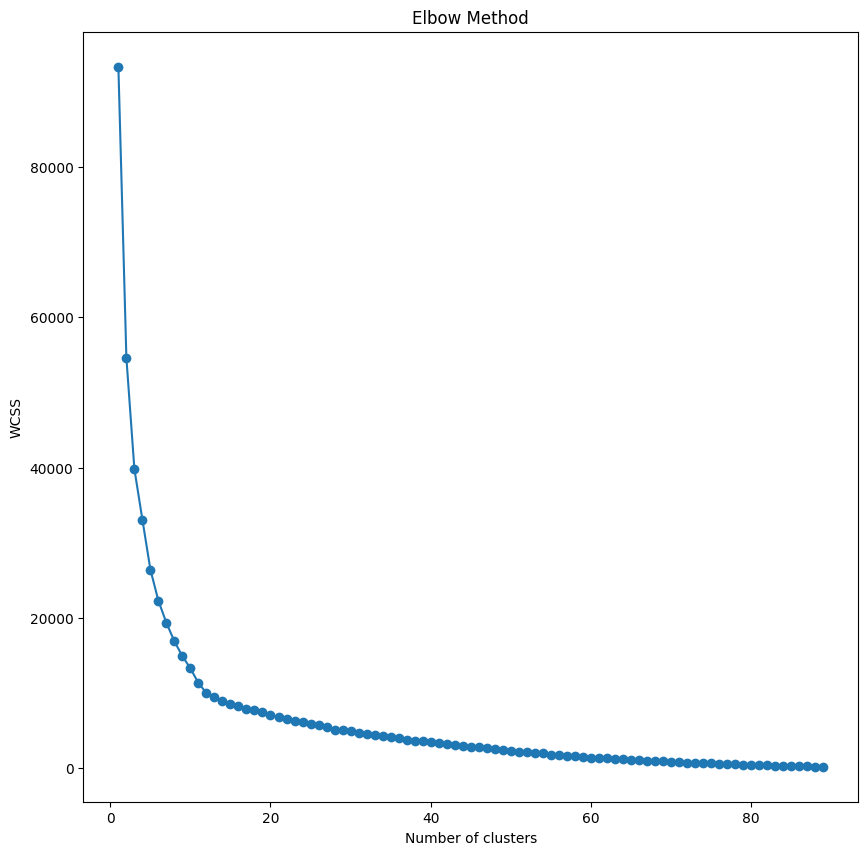

In [13]:
# Elbow method plotting
plt.figure(figsize=(10,10))
plt.plot(range(1, 90), wcss, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [14]:
# Create a pairplot with the specified colors
# sns.pairplot(component_wise_df, hue='Cluster', palette='tab10')
# plt.show()

## DBSCAN


[ 0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0
  0  0  0]
Número estimado de clusters: 1


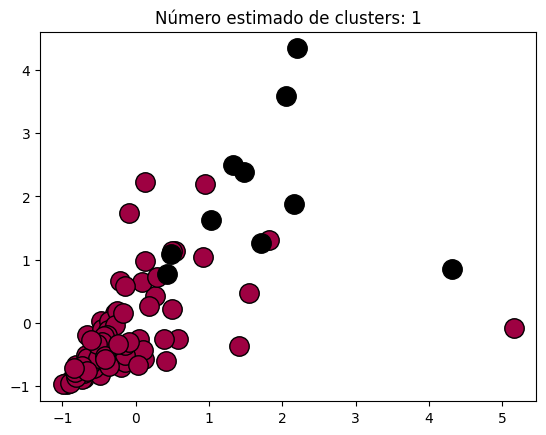

Silhouette Score: 0.7344808926621688
Davies-Bouldin Score: 1.0998733896938044
Calinski-Harabasz Score: 68.82410494261677


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Seleccionar columnas numéricas
numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Aplicar DBSCAN
db = DBSCAN(eps=30, min_samples=2).fit(scaled_data)
labels = db.labels_
print(labels)

# Número de clusters en las etiquetas, ignorando el ruido si está presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(f'Número estimado de clusters: {n_clusters_}')

silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# Visualizar los resultados
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro se usa para ruido.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = scaled_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

plt.title(f'Número estimado de clusters: {n_clusters_}')
plt.show()

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

### Agglomerative Clustering

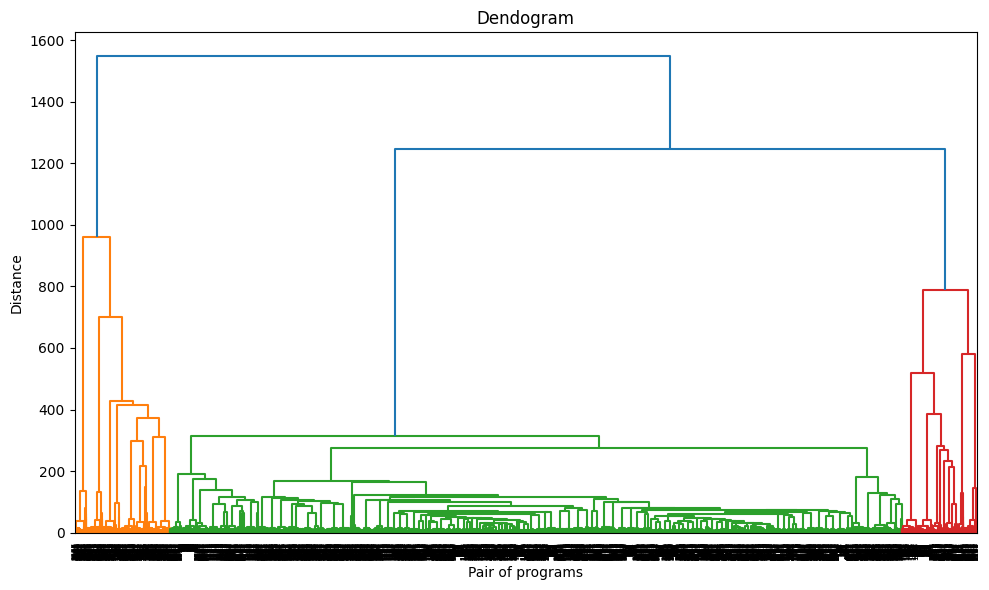

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

Z = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=data.index.values, orientation='top')
plt.title("Dendogram")
plt.xlabel("Pair of programs")
plt.ylabel("Distance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.cluster import AgglomerativeClustering

cluster_ward_1 = AgglomerativeClustering(n_clusters=8, linkage='ward')# For data of differences
cluster_ward_2 = AgglomerativeClustering(n_clusters=10, linkage='ward')

# cluster_ward_1 = AgglomerativeClustering(n_clusters=30, linkage='ward')
# cluster_ward_2 = AgglomerativeClustering(n_clusters=35, linkage='ward')

y_ward_1 = cluster_ward_1.fit_predict(scaled_data)
y_ward_2 = cluster_ward_2.fit_predict(scaled_data)

data['agglomerative_ward_2'] = y_ward_2
data['agglomerative_ward_1'] = y_ward_1

In [18]:
# Create a pairplot with the specified colors
# sns.pairplot(data, hue='agglomerative_ward_2', palette='viridis')
# plt.show()

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_avg_agg_1 = silhouette_score(scaled_data, y_ward_1)
silhouette_avg_agg_2 = silhouette_score(scaled_data, y_ward_2)

davies_bouldin_avg_agg_1 = davies_bouldin_score(scaled_data, y_ward_1)
davies_bouldin_avg_agg_2 = davies_bouldin_score(scaled_data, y_ward_2)

calinski_harabasz_avg_agg_1 = calinski_harabasz_score(scaled_data, y_ward_1)
calinski_harabasz_avg_agg_2 = calinski_harabasz_score(scaled_data, y_ward_2)

# Look for values closer to one
print(f'Silhouette Score for x clusters: {silhouette_avg_agg_1}')
print(f'Silhouette Score for y clusters: {silhouette_avg_agg_2}')

# Look for bigger values
print(f'Calinski Harabaz Score for x clusters: {calinski_harabasz_avg_agg_1}')
print(f'Calinski Harabaz Score for y clusters: {calinski_harabasz_avg_agg_2}')

# Look for smaller values
print(f'Davies Bouldin Score for x clusters: {davies_bouldin_avg_agg_1}')
print(f'Davies Bouldin Score for y clusters: {davies_bouldin_avg_agg_2}')

Silhouette Score for x clusters: 0.6198389347571299
Silhouette Score for y clusters: 0.6186863702468378
Calinski Harabaz Score for x clusters: 1762.5084429604487
Calinski Harabaz Score for y clusters: 1672.8273404791796
Davies Bouldin Score for x clusters: 0.807428871345101
Davies Bouldin Score for y clusters: 0.7646041786095532


## MeanShift

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Seleccionar columnas numéricas
numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Estimar el ancho de banda para MeanShift
bandwidth = estimate_bandwidth(scaled_data, quantile=0.4, n_samples=500)

# Aplicar MeanShift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(scaled_data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Número de clusters
n_clusters_ = len(np.unique(labels))

print(f'Número estimado de clusters: {n_clusters_}')

# Calcular métricas
silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# Visualizar los resultados
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = scaled_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

# Dibujar los centros de los clusters
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=22, alpha=0.5)

plt.title(f'Número estimado de clusters: {n_clusters_}')
plt.show()

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')


Número estimado de clusters: 1


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## SpectralClustering

Silhouette Score: 0.00041979897473697953
Davies-Bouldin Score: 2.621841090439065
Calinski-Harabasz Score: 9.289929778217932


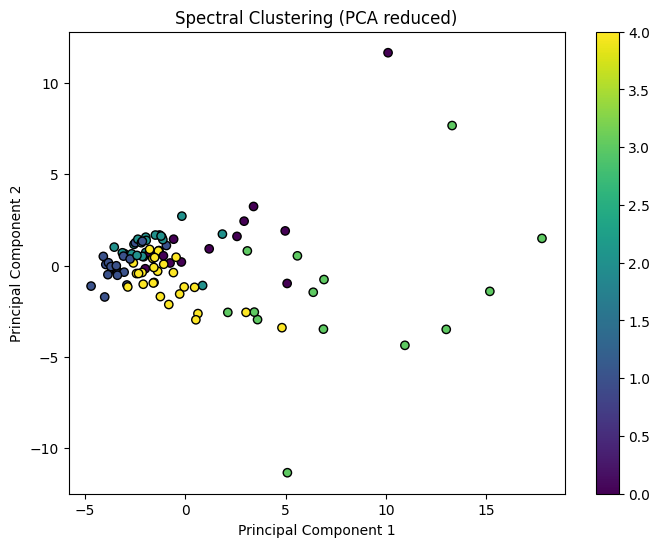

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas numéricas
numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Aplicar Spectral Clustering
n_clusters = 5  # Número de clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(scaled_data)

# Calcular métricas de evaluación
silhouette_avg = silhouette_score(scaled_data, labels)
davies_bouldin_avg = davies_bouldin_score(scaled_data, labels)
calinski_harabasz_avg = calinski_harabasz_score(scaled_data, labels)

# Reducir la dimensionalidad para visualización con PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title('Spectral Clustering (PCA reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')
plt.show()

## Siamese NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from SNN.siamese_network_parse import PrepareDataSNN

# Definir la arquitectura base
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Definir la función de distancia
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Crear el modelo de red siamesa
def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Obtener las representaciones de las dos ramas
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calcular la distancia entre las dos salidas
    distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

# Definir la función de pérdida
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Entrenar el modelo
def train_siamese_network(data_a, data_b, labels):
    input_shape = (data_a.shape[1],)
    model = create_siamese_network(input_shape)

    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

    model.fit([data_a, data_b], labels, batch_size=128, epochs=20)

# Ejecutar el entrenamiento
if __name__ == "__main__":
    data = PrepareDataSNN()
    data_a, data_b, labels = data.process()
    train_siamese_network(data_a, data_b, labels)


KeyboardInterrupt: 

In [ ]:
import networkx as nx
from antlr4 import *
from antlr4 import CommonTokenStream
from Python.CSharpLexer import CSharpLexer
from Python.CSharpParser import CSharpParser
import json, os
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph

class ASTToGraphVisitor:
    def __init__(self):
        self.graph = nx.DiGraph()  # Usamos un grafo dirigido
        self.node_count = 0

    def next_node_id(self):
        self.node_count += 1
        return self.node_count

    def add_node(self, node, label):
        node_id = self.next_node_id()
        self.graph.add_node(node_id, label=label)
        return node_id

    def visitChildren(self, node):
        current_node_id = self.add_node(node, type(node).__name__)
        for child in node.getChildren():
            if isinstance(child, TerminalNode):
                child_id = self.add_node(child, child.getText())
            else:
                child_id = self.visitChildren(child)
            self.graph.add_edge(current_node_id, child_id)
        return current_node_id

# Método para convertir un AST a un grafo
def convert_ast_to_graph(input_code):
    input_stream = InputStream(input_code)
    lexer = CSharpLexer(input_stream)
    stream = CommonTokenStream(lexer)
    parser = CSharpParser(stream)
    tree = parser.compilation_unit()  # Cambia 'startRule' por la regla inicial de tu gramática

    visitor = ASTToGraphVisitor()
    visitor.visitChildren(tree)
    return visitor.graph

# Método para dibujar el grafo utilizando matplotlib
def draw_graph(graph):
    agraph = to_agraph(graph)
    agraph.layout(prog='dot')  # Usar el motor 'dot' para el posicionamiento
    agraph.draw('ast_graph.png')  # Guardar el grafo como imagen PNG

json_file_path = f'{os.getcwd()}/Projects/All/Ab3lucho_Moogle/Moogle-main/MoogleEngine/Query.cs'


with open(json_file_path, 'r') as file:
    code = file.read()
        
graph = convert_ast_to_graph(code)

# Imprimir el grafo
print(len(graph.nodes))
print(graph.nodes(data=True))
print(graph.edges())




7744
[(1, {'label': 'Compilation_unitContext'}), (2, {'label': 'Using_directivesContext'}), (3, {'label': 'UsingNamespaceDirectiveContext'}), (4, {'label': 'using'}), (5, {'label': 'Namespace_or_type_nameContext'}), (6, {'label': 'IdentifierContext'}), (7, {'label': 'System'}), (8, {'label': '.'}), (9, {'label': 'IdentifierContext'}), (10, {'label': 'Collections'}), (11, {'label': '.'}), (12, {'label': 'IdentifierContext'}), (13, {'label': 'Generic'}), (14, {'label': ';'}), (15, {'label': 'UsingNamespaceDirectiveContext'}), (16, {'label': 'using'}), (17, {'label': 'Namespace_or_type_nameContext'}), (18, {'label': 'IdentifierContext'}), (19, {'label': 'System'}), (20, {'label': ';'}), (21, {'label': 'UsingNamespaceDirectiveContext'}), (22, {'label': 'using'}), (23, {'label': 'Namespace_or_type_nameContext'}), (24, {'label': 'IdentifierContext'}), (25, {'label': 'System'}), (26, {'label': '.'}), (27, {'label': 'IdentifierContext'}), (28, {'label': 'IO'}), (29, {'label': ';'}), (30, {'lab

In [ ]:
# Visualizar el grafo
draw_graph(graph)

KeyboardInterrupt: 